In [198]:
%load_ext autoreload
%autoreload 2
import gym
from gym import spaces
import numpy as np
from gym_examples.envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [573]:
#generate data

env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(10000):
    state = env.reset()
    for action in range(env.action_space.n):
        X.append(state)
        r = env.sample(state, action, 0)
        y.append(r)

X = np.array(X)
y = np.array(y)



In [598]:
#generate data

env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(100000):
    state = env.reset()
    X.append(state)

X = np.array(X)


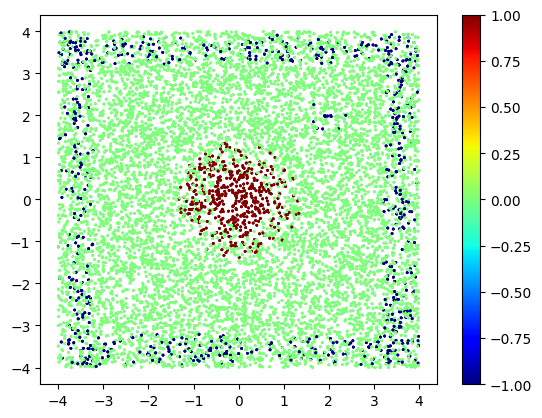

In [574]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X[:,0], X[:,1], c=y, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
#plt.show()
plt.savefig('env.png')

In [285]:
np.min(y)

0

In [311]:
np.random.shuffle(X)

In [589]:
#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(9)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(1)(l2)

    return l3.ravel()

# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse



optimizer = optax.yogi(learning_rate=1e-2)
opt_state = optimizer.init(params)
batch_size = len(X)

#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(100):
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.9)
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        print("progress:", "epoch:", epoch, "loss",loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
    
    
# After training
print("estimation of the parameters:")
print(params)

estimate  = forward(X=env.reset(), params=params)
print("estimate", estimate)

progress: epoch: 0 loss 0.14098294
progress: epoch: 1 loss 0.12590304
progress: epoch: 2 loss 0.11274112
progress: epoch: 3 loss 0.101276085
progress: epoch: 4 loss 0.090506844
progress: epoch: 5 loss 0.08113129
progress: epoch: 6 loss 0.072940454
progress: epoch: 7 loss 0.06581488
progress: epoch: 8 loss 0.059762646
progress: epoch: 9 loss 0.054419763
progress: epoch: 10 loss 0.05079589
progress: epoch: 11 loss 0.04827541
progress: epoch: 12 loss 0.045287643
progress: epoch: 13 loss 0.042950355
progress: epoch: 14 loss 0.04132678
progress: epoch: 15 loss 0.040136255
progress: epoch: 16 loss 0.039374158
progress: epoch: 17 loss 0.039017804
progress: epoch: 18 loss 0.039099365
progress: epoch: 19 loss 0.03841109
progress: epoch: 20 loss 0.038622838
progress: epoch: 21 loss 0.038549908
progress: epoch: 22 loss 0.038726132
progress: epoch: 23 loss 0.03887448
progress: epoch: 24 loss 0.039022777
progress: epoch: 25 loss 0.038942736
progress: epoch: 26 loss 0.03935387
progress: epoch: 27 lo

In [600]:

y_pred = [forward(X=x, params=params) for x in X]

In [601]:
max(y_pred)

Array([1.8734457], dtype=float32)

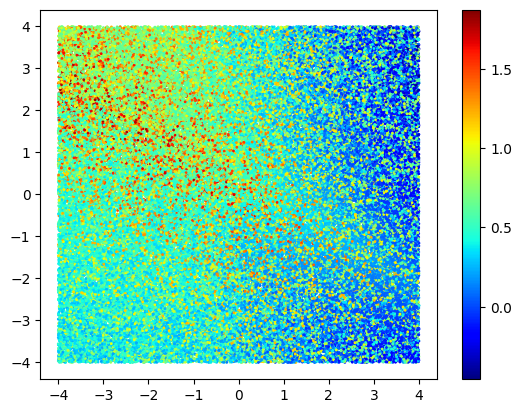

In [602]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X[:,0], X[:,1], c=y_pred, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.savefig('100_iter_adabeleif.png')
plt.show()


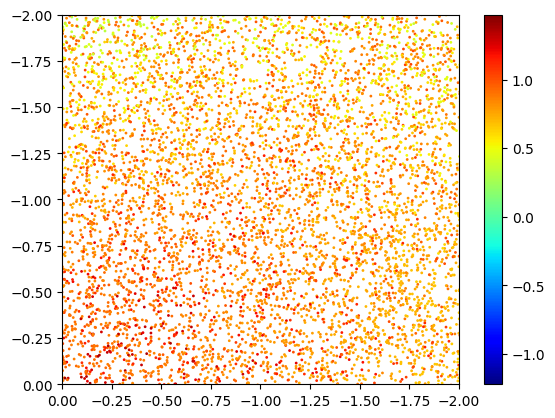

In [488]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X[:,0], X[:,1], c=y_pred, s=1) # s is a size of marker 
plt.axis([0, -2, 0, -2])

plt.jet()
plt.colorbar()

plt.show()
#plt.savefig('50

In [615]:
#train on small steps, run on bigger steps?
env = DubinsCarEnv()
state = env.reset()
gamma = 0.9
traj = []
done = False
max_iter = 100
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        estimate = forward(X=next_state, params=params)
        value = reward + gamma*estimate[0]
        print('estimate', value, 'actual', reward, "shape",next_state.shape)

        possible_actions.append(estimate[0])
        #possible_actions.append(reward)
    action = np.argmax(np.array(possible_actions))
    print(action, possible_actions)
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
#env.make_gif()

/home/apraka15/Documents/Projects/Reach-Avoid/gym-examples/.env/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


estimate 1.0281587 actual 0 shape (3,)
estimate 0.61863244 actual 0 shape (3,)
estimate 0.49416 actual 0 shape (3,)
0 [Array(1.1423986, dtype=float32), Array(0.6873694, dtype=float32), Array(0.54906666, dtype=float32)]
1
estimate 1.424381 actual 0 shape (3,)
estimate 0.86195624 actual 0 shape (3,)
estimate 0.5139535 actual 0 shape (3,)
0 [Array(1.5826457, dtype=float32), Array(0.95772916, dtype=float32), Array(0.57105947, dtype=float32)]
2
estimate 1.8196646 actual 0 shape (3,)
estimate 1.2572399 actual 0 shape (3,)
estimate 0.7349123 actual 0 shape (3,)
0 [Array(2.0218496, dtype=float32), Array(1.3969333, dtype=float32), Array(0.8165692, dtype=float32)]
3
estimate 2.213643 actual 0 shape (3,)
estimate 1.670964 actual 0 shape (3,)
estimate 1.1085392 actual 0 shape (3,)
0 [Array(2.4596035, dtype=float32), Array(1.8566267, dtype=float32), Array(1.2317103, dtype=float32)]
4
estimate 2.5846925 actual 0 shape (3,)
estimate 2.0570753 actual 0 shape (3,)
estimate 1.5294584 actual 0 shape (3,)

In [610]:
xt = np.array(traj)[:,0]
yt = np.array(traj)[:,1]
print(len(xt), len(yt))

500 500


In [611]:
xt

array([-1.6476096, -1.5068904, -1.5946231, -1.6945956, -1.7799802,
       -1.8278639, -1.8253971, -1.7732418, -1.6853938, -1.5854273,
       -1.5001683, -1.4524962, -1.4552037, -1.5075643, -1.595527 ,
       -1.695487 , -1.78062  , -1.8280804, -1.8251323, -1.7725666,
       -1.6844895, -1.5845366, -1.4995302, -1.452282 , -1.4554709,
       -1.5082413, -1.5964321, -1.6963773, -1.7812566, -1.8282924,
       -1.8248627, -1.7718879, -1.6835837, -1.5836468, -1.4988952,
       -1.452072 , -1.4557424, -1.5089213, -1.5973382, -1.6972663,
       -1.7818899, -1.8285002, -1.8245891, -1.7712064, -1.6826773,
       -1.5827585, -1.4982635, -1.4518664, -1.456018 , -1.5096042,
       -1.5982451, -1.6981539, -1.7825198, -1.8287034, -1.8243111,
       -1.7705218, -1.6817696, -1.5818715, -1.4976351, -1.4516653,
       -1.4562979, -1.5102898, -1.5991523, -1.6990393, -1.7831463,
       -1.8289031, -1.824031 , -1.7698375, -1.6808653, -1.58099  ,
       -1.497013 , -1.4514694, -1.4565809, -1.5109757, -1.6000

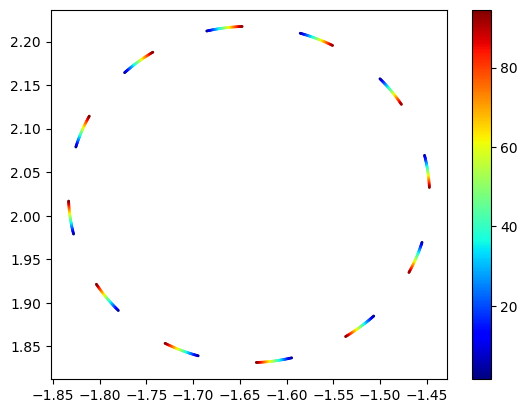

In [612]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

In [486]:
yp

[Array([10.395088  ,  0.82039297,  0.9479599 ,  1.0707818 ,  1.1834116 ,
         1.2831379 ,  1.3707105 ,  1.4501419 ,  1.5276291 ,  1.6098907 ,
         1.7023637 ,  1.8077453 ,  1.925269  ,  2.050909  ,  2.1784625 ,
         2.3012123 ,  2.413731  ,  2.5133362 ,  2.6008115 ,  2.6801949 ,
         2.7576962 ,  2.8400297 ,  2.9326143 ,  3.038117  ,  3.1442208 ,
         3.2588172 ,  3.3874269 ,  3.5206795 ,  3.6440492 ,  3.743534  ,
         3.830912  ,  3.9102478 ,  3.9839892 ,  4.0381193 ,  4.098271  ,
         4.1734433 ,  4.268606  ,  4.383364  ,  4.5120635 ,  4.645309  ,
         4.772486  ,  4.884609  ,  4.97673   ,  5.049271  ,  5.1079073 ,
         5.162045  ,  5.222298  ,  5.29764   ,  5.392993  ,  5.5079117 ,
         5.6366997 ,  5.769938  ,  5.897013  ,  6.008967  ,  6.100898  ,
         6.1732783 ,  6.2318254 ,  6.285971  ,  6.3463264 ,  6.4218364 ,
         6.5173798 ,  6.632459  ,  6.761334  ,  6.894563  ,  7.021536  ,
         7.1333203 ,  7.225061  ,  7.297281  ,  7.3

In [614]:
next_state

array([  -1.5860633,    1.8961817, -259.533    ], dtype=float32)